## Import libraries:

In [6]:
from imports import *

# Individual coordinate reconstruction (t,x,y,z)

## Training and test separation

In [7]:
table = pq.read_table('saved_archives/ophit_variables.parquet')
hit_nuvT_f = ak.from_iter(table.column('hit_nuvT_f').to_pylist())
del table

KeyboardInterrupt: 

In [3]:
def create_cnn_model(x_train, conv_dim, maxpool_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    masking_layer = layers.Masking(mask_value=0)(input_layer)
    
    # First convolutional block
    model = layers.BatchNormalization()(masking_layer)
    model = layers.Conv2D(32, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)
    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.2)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.2)(model)
    
    # Output layer
    output_layer = layers.Dense(1, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

**VIS/VUV**

In [4]:
x_train_realistic_visvuv, x_test_realistic_visvuv, train_nuvT_realistic_visvuv, test_nuvT_realistic_visvuv = split_train_test("/data/vidales/images/image_realistic_visvuv.npy", hit_nuvT_f, test_ratio=0.20)
x_train_compressed_visvuv, x_test_compressed_visvuv, train_nuvT_compressed_visvuv, test_nuvT_compressed_visvuv= split_train_test("/data/vidales/images/image_compressed_visvuv.npy", hit_nuvT_f, test_ratio=0.20)

Test size: 5784
x_train shape: (23137, 59, 70, 8), x_test shape: (5784, 59, 70, 8)
train_nuvT length: 23137, test_nuvT length: 5784
Test size: 5784
x_train shape: (23137, 9, 36, 8), x_test shape: (5784, 9, 36, 8)
train_nuvT length: 23137, test_nuvT length: 5784


In [5]:
model_realistic_visvuv = create_cnn_model(x_train_realistic_visvuv,(3,5),(2,2))
nuvT_pred_realistic_visvuv, history_t_realistic_visvuv = train_and_predict(model_realistic_visvuv, x_train_realistic_visvuv, train_nuvT_realistic_visvuv, x_test_realistic_visvuv, test_nuvT_realistic_visvuv, epochs=50, batch_size=32)

Epoch 1/50
724/724 [==============================] - 12s 12ms/step - loss: 94117.8203 - mse: 94117.8203 - val_loss: 227562.9688 - val_mse: 227562.9688
Epoch 2/50
724/724 [==============================] - 7s 9ms/step - loss: 54317.2109 - mse: 54317.2109 - val_loss: 92339.8984 - val_mse: 92339.8984
Epoch 3/50
724/724 [==============================] - 7s 9ms/step - loss: 36046.9375 - mse: 36046.9375 - val_loss: 38583.6953 - val_mse: 38583.6953
Epoch 4/50
724/724 [==============================] - 7s 9ms/step - loss: 33695.1602 - mse: 33695.1602 - val_loss: 32430.5469 - val_mse: 32430.5469
Epoch 5/50
724/724 [==============================] - 7s 9ms/step - loss: 31000.1035 - mse: 31000.1035 - val_loss: 15257.2197 - val_mse: 15257.2197
Epoch 6/50
724/724 [==============================] - 6s 9ms/step - loss: 29172.9238 - mse: 29172.9238 - val_loss: 57956.6367 - val_mse: 57956.6367
Epoch 7/50
724/724 [==============================] - 6s 9ms/step - loss: 29776.5020 - mse: 29776.5020 - val

## Visualización de las representaciones intermedias

Se visualiza las características intermedias aprendidas por la CNN. Se puede observar como la entrada se transforma al pasar através de las capas. Se selecciona una imagen aleatoria del conjunto de entrenamiento y se visualiza durante su transformación. Cada fila corresponde con una capa y cada imagen en la fila con un filtro.

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Se define un nuevo modelo que tendrá como entrada la imagen,
# y como salida la representación intermedia de todas las capas.
successive_outputs = [layer.output for layer in model_realistic_visvuv.layers[1:]]
visualization_model = Model(masking_layer, successive_outputs)

# Se elige aleatoriamente una imagen del conjunto de entrenamiento.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(image_size, image_size))  # this is a PIL image
x = img_to_array(img)  # Array Numpy array con dimensiones (image_size, image_size, 3)
x = x.reshape((1,) + x.shape)  # Array Numpy array con dimensiones (1, image_size, image_size, 3)

# Reescalar por 1/255
x /= 255

# Se hace pasar la imagen através de la red.
# Así se obtienen sus presentaciones intermedias.
successive_feature_maps = visualization_model.predict(x)

# Se obtienen los nombres de las capas.
layer_names = [layer.name for layer in model.layers]

# Dibjar representaciones
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Hacer con las capas convolucionales y max-pooling, pero no con las densas
    n_features = feature_map.shape[-1]  # número de características en un mapa
    # El mapa tiene dimensiones (1, size, size, n_features)
    size = feature_map.shape[1]
    # Título en las imágenes
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Reprocesar para hacer visualizable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Horizontal display
      display_grid[:, i * size : (i + 1) * size] = x
    # Mostrar
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [28]:
model_compressed_visvuv = create_cnn_model(x_train_compressed_visvuv)
nuvT_pred_compressed_visvuv, history_t_compressed_visvuv = train_and_predict(model_compressed_visvuv, x_train_compressed_visvuv, train_nuvT_compressed_visvuv, x_test_compressed_visvuv, test_nuvT_compressed_visvuv, epochs=30, batch_size=32)

Epoch 1/30
317/317 - 3s - loss: 127869.7656 - mse: 127869.7656 - val_loss: 860725.5625 - val_mse: 860725.5625 - 3s/epoch - 10ms/step
Epoch 2/30
317/317 - 2s - loss: 71200.7734 - mse: 71200.7734 - val_loss: 79388.7578 - val_mse: 79388.7578 - 2s/epoch - 6ms/step
Epoch 3/30
317/317 - 2s - loss: 57775.5469 - mse: 57775.5469 - val_loss: 37114.8555 - val_mse: 37114.8555 - 2s/epoch - 6ms/step
Epoch 4/30
317/317 - 2s - loss: 57291.5312 - mse: 57291.5312 - val_loss: 29450.9316 - val_mse: 29450.9316 - 2s/epoch - 6ms/step
Epoch 5/30
317/317 - 2s - loss: 47602.8750 - mse: 47602.8750 - val_loss: 86537.2891 - val_mse: 86537.2891 - 2s/epoch - 6ms/step
Epoch 6/30
317/317 - 2s - loss: 43653.3828 - mse: 43653.3828 - val_loss: 30744.9121 - val_mse: 30744.9121 - 2s/epoch - 6ms/step
Epoch 7/30
317/317 - 2s - loss: 39806.7930 - mse: 39806.7930 - val_loss: 21905.7207 - val_mse: 21905.7207 - 2s/epoch - 6ms/step
Epoch 8/30
317/317 - 2s - loss: 37554.4492 - mse: 37554.4492 - val_loss: 29557.3574 - val_mse: 2955

## 4-components

In [4]:
x_train_realistic_4comp, x_test_realistic_4comp, train_nuvT_realistic_4comp, test_nuvT_realistic_4comp = split_train_test("/data/vidales/images/image_realistic_4comp.npy", hit_nuvT_f, test_ratio=0.20)
x_train_compressed_4comp, x_test_compressed_4comp, train_nuvT_compressed_4comp, test_nuvT_compressed_4comp= split_train_test("/data/vidales/images/image_compressed_4comp.npy", hit_nuvT_f, test_ratio=0.20)

Test size: 5916
x_train shape: (23666, 59, 70, 16), x_test shape: (5916, 59, 70, 16)
train_nuvT length: 23666, test_nuvT length: 5916
Test size: 5916
x_train shape: (23666, 9, 36, 16), x_test shape: (5916, 9, 36, 16)
train_nuvT length: 23666, test_nuvT length: 5916


In [5]:
model_realistic_4comp = create_cnn_model(x_train_realistic_4comp, (3,5),(2,2))
nuvT_pred_realistic_4comp, history_t_realistic_4comp = train_and_predict(model_realistic_4comp, x_train_realistic_4comp, train_nuvT_realistic_4comp, x_test_realistic_4comp, test_nuvT_realistic_4comp, epochs=30, batch_size=32)

KeyboardInterrupt: 

In [ ]:
model_compressed_4comp = create_cnn_model(x_train_compressed_4comp, (3,5),(2,2))
nuvT_pred_compressed_4comp, history_t_compressed_4comp = train_and_predict(model_compressed_4comp, x_train_compressed_4comp, train_nuvT_compressed_4comp, x_test_compressed_4comp, test_nuvT_compressed_4comp, epochs=30, batch_size=32)

# Visualización de resultados

MSE computed:

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

testScoreMSE_nuvT = mean_squared_error(test_nuvT_realistic_visvuv, nuvT_pred_realistic_visvuv)
r2 = r2_score(test_nuvT_realistic_visvuv, nuvT_pred_realistic_visvuv)
mape = mean_absolute_percentage_error(test_nuvT_realistic_visvuv, nuvT_pred_realistic_visvuv)

print('RMSE: %.3f' % np.sqrt((testScoreMSE_nuvT)))
print('R²: %.3f' % r2)
print('MAPE: %.2f%%' % mape)

RMSE: 112.959
R²: 0.935
MAPE: 54.91%


The next plot visualizes the evolution of loss over epochs for the training and test set.

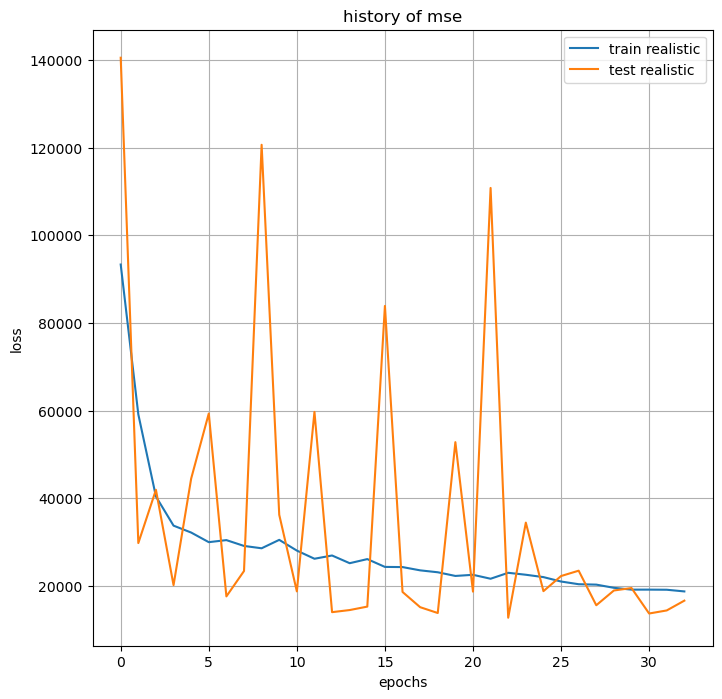

In [8]:
plt.figure(1, figsize=(8,8))
plt.plot(history_t_realistic_visvuv.history['mse'])
plt.plot(history_t_realistic_visvuv.history['val_mse'])
#plt.plot(history_t_compressed_visvuv.history['mse'])
#plt.plot(history_t_compressed_visvuv.history['val_mse'])

#plt.yscale("log")
plt.title('history of mse')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train realistic', 'test realistic', 'train compressed', 'test compressed'], loc='upper right')
#plt.ylim(10**4,2*10**6)
plt.show()

The next plot shows the predicted over real data, it shows the error distribution.

In [12]:
def plot_predictions_vs_real(test_nuvT, pred_nuvT):
    fig, axs = plt.subplots(1, 2, figsize=(14, 9))
    fig.suptitle("Predicted vs Real")

    # Scatter plot
    axs[0].scatter(test_nuvT, pred_nuvT, color="black", s=5)
    axs[0].grid()
    axs[0].plot([350, 1800], [350, 1800], color="r")
    axs[0].title.set_text('nuvT')
    #axs[0].set_xlim([-1, 20])
    #axs[0].set_ylim([-1, 20])
    axs[0].set_ylabel('Predicted [ns]')
    axs[0].set_xlabel('Real [ns]')

    # 2D histogram
    im1 = axs[1].hist2d(test_nuvT, pred_nuvT.flatten(), bins=(100, 300), cmap='viridis', cmax=30)
    axs[1].grid()
    #axs[1].plot([-1, 20], [-1, 20], color="r")
    #axs[1].set_xlim([-1, 20])
    #axs[1].set_ylim([-1, 20])
    axs[1].set_ylabel('Predicted [ns]')
    axs[1].set_xlabel('Real [ns]')
    axs[1].set_facecolor('#440154')

    fig.tight_layout()
    
    # Uncomment to save the figure
    # plt.savefig('/tmp/CNNx2+4T+N_Recta_I.png', dpi=300)

    plt.show()

# Example usage
# plot_predictions_vs_real(test_nuvT, nuvT_pred_realistic)


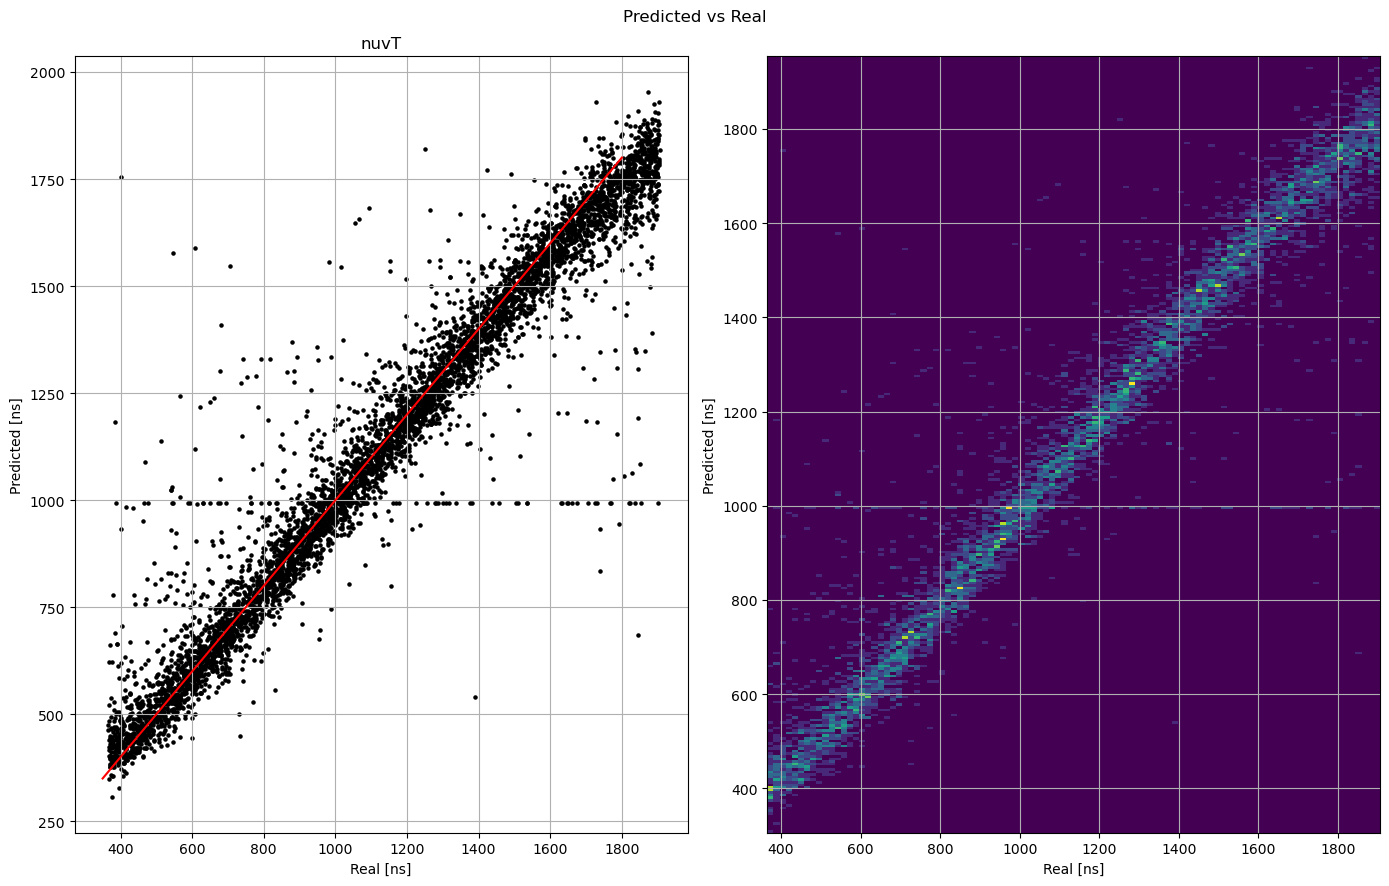

In [13]:
plot_predictions_vs_real(test_nuvT_realistic_visvuv, nuvT_pred_realistic_visvuv)

Finally, Gaussian adjustments are made to the error between prediction and actual data to check the quality of the results.

------------------
Media nuvT = 5.580523491402194
Sigma nuvT = 52.49821478635204
------------------


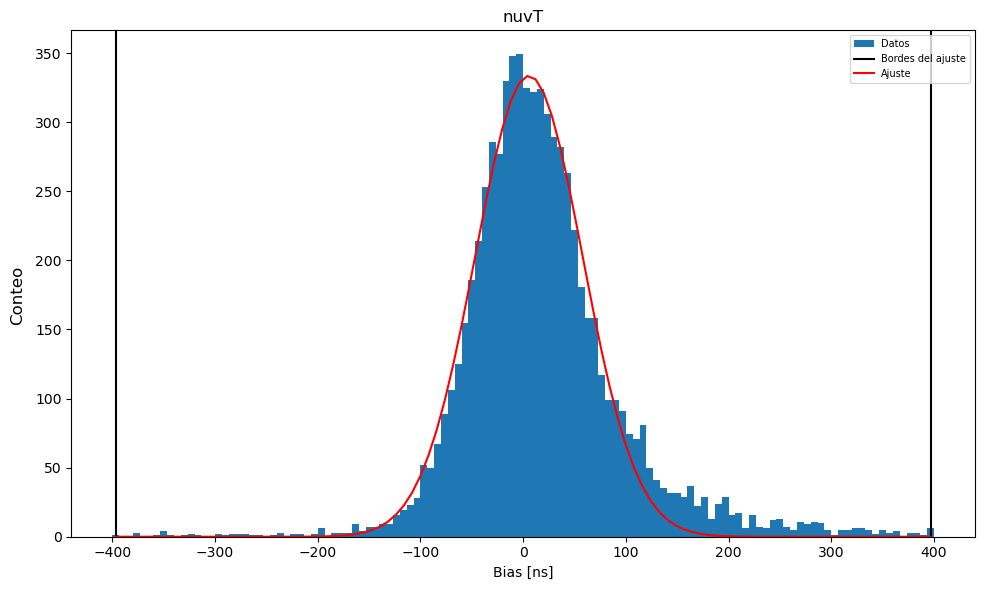

In [16]:
# Gaussian fit of the difference between the prediction and the real value

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred_realistic.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Data')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Edge"s fit')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Fit')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Count')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Mean nuvT =',popt_nuvT[1])
print('St. Dev. nuvT =',popt_nuvT[2])
print('------------------')


In [17]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

Gauss nuvT
115.17707820363492
24.574550175010334
